In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
noise = np.random.normal(0,1,(1000000,100)) 
noise_cov = np.cov(noise.T)


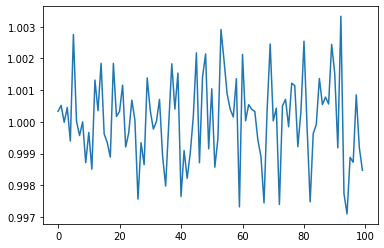

In [3]:
plt.plot(np.diag(noise_cov))

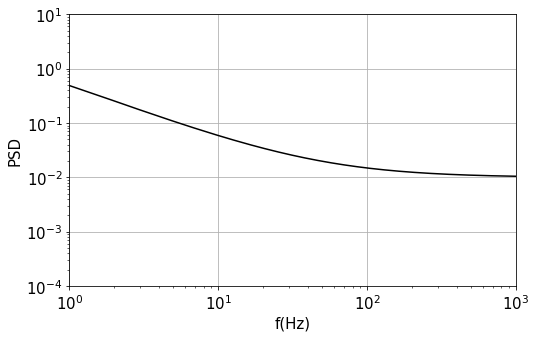

In [10]:
def generate_psd(steady,slope, half_fs, num_points, top):
    f = np.linspace(1e-6,half_fs,num_points)
    
    f_below1 = f[f<1]
    f_above1 = f[f>=1]
    f_below1_response = top*np.ones_like(f_below1)
    f_above1_response = steady + (top-steady)*np.power(f_above1,-slope)
    response = np.concatenate((f_below1_response, f_above1_response))
    
#     A = 1/steady 
#     response = (A+f**(slope))/(1+A*f**(slope))
#     omega = 2*np.pi*f
#     response_top = (1j*omega-2*np.pi*steady)
#     response_end = (1j*omega-1)
#     response = (response_top**slope)/(response_end**slope)
#     response = np.abs(response)**2

    return f, response

N=2048
half = int(N/2)+1
half_fs = 1000

f,response1 = generate_psd(0.01,1,half_fs,half,0.5)
f,response2 = generate_psd(1,1,half_fs,half,10)
f,response3 = generate_psd(0.01,2,half_fs,half,1)
f,response4 = generate_psd(0.001,3,half_fs,half,0.001)
plt.figure(figsize=(8,5))
plt.loglog(f,response1,label='$bg_{f}: -20dB, p_{bg}: -1, bg_{r}=10dB$',c='k')
# plt.loglog(f,response2,label='$bg_{f}: 0dB, p_{bg}: -1, bg_{r}=10dB$',c='r')
# plt.loglog(f,response3,label='$bg_{f}: -20dB, p_{bg}: -2, bg_{r}=0dB$',c='g')
# plt.loglog(f,response4,label='$bg_{f}: -30dB, p_{bg}: -3, bg_{r}=-30dB$',c='b')

plt.xlim([1,1000])
plt.ylim([1e-4,10])
#plt.legend(loc='lower right',fontsize=10)
plt.grid()
plt.xlabel('f(Hz)',fontsize=15)
plt.ylabel('PSD',fontsize=15)
plt.tick_params(labelsize=15)
plt.savefig('PSD.jpg')
tresponse1 = np.concatenate((response1, response1[1:-1:][::-1]))
tresponse2 = np.concatenate((response2, response2[1:-1:][::-1]))
tresponse3 = np.concatenate((response3, response3[1:-1:][::-1]))
tresponse4 = np.concatenate((response4, response4[1:-1:][::-1]))

In [59]:
response1

array([10.        , 10.        ,  5.12048538, ...,  0.01101857,
        0.01100877,  0.010999  ])

In [176]:
psd = []
seq = []
psd_signal = []
num_sample = 1000
signal = np.cos(2*np.pi*400*np.arange(0,N)/(2*half_fs))
for i in range(num_sample):
    white_sequence = np.random.normal(0,1,N)
    white_sequence_fft = np.fft.fft(white_sequence)
    response1_mag = np.sqrt(tresponse1)
    result_mag = response1_mag*white_sequence_fft
    inverse = np.fft.ifft(result_mag)
    response1_time = np.real(inverse)
    seq.append(response1_time)
    
    signal_time = response1_time+signal
    k = 1/N * (np.abs(np.fft.fft(response1_time))**2)
    u = 1/N * (np.abs(np.fft.fft(signal_time))**2)
    psd.append(k)
    psd_signal.append(u)

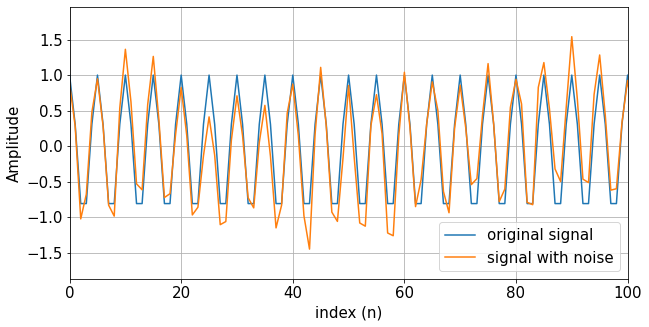

In [178]:
plt.figure(figsize=(10,5))
plt.plot(signal,label='original signal')
plt.plot(signal_time,label='signal with noise')
plt.grid()
plt.xlabel('index (n)',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.tick_params('both',labelsize=15)
plt.xlim([0,100])
plt.legend(fontsize=15)
plt.savefig('time.jpg')

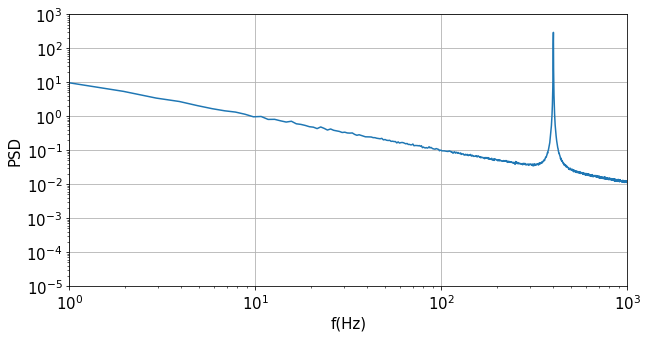

In [179]:
psd_mean = np.array(psd).mean(0)
psd_signal_mean = np.array(psd_signal).mean(0)
plt.figure(figsize=(10,5))
plt.loglog(f,psd_signal_mean[0:half])
plt.xlim([1,1000])
plt.ylim([1e-5,1000])
plt.grid()
plt.xlabel('f(Hz)',fontsize=15)
plt.ylabel('PSD', fontsize=15)
plt.tick_params('both',labelsize=15)
plt.savefig('signal.jpg')

In [180]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation
cov = np.cov(seq.T)
R = correlation_from_covariance(cov )

AttributeError: 'list' object has no attribute 'T'

In [65]:
def get_rows(grid):
    return [[c for c in r] for r in grid]

def get_cols(grid):
    return zip(*grid)

def get_forward_diagonals(grid):
    b = [None] * (len(grid) - 1)
    grid = [b[:i] + r + b[i:] for i, r in enumerate(get_rows(grid))]
    return [np.mean([c for c in r if c is not None]) for r in get_cols(grid)]

def get_backward_diagonals(grid):
    b = [None] * (len(grid) - 1)
    A=get_rows(grid)
    B=get_cols(grid)
    grid = [b[i:] + r + b[:i] for i, r in enumerate(A)]        
    return [np.array([c for c in r if c is not None]).mean() for r in B]

In [66]:
m = get_forward_diagonals(R[:,::-1])

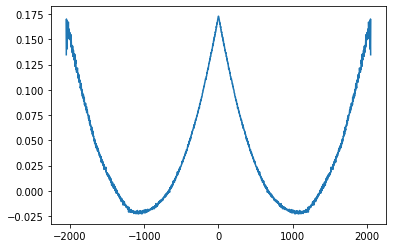

In [67]:
plt.plot(np.linspace(-N,N,len(m))[::2],m[::2])

In [68]:
l = np.fft.fft(m[int(len(m)/2):])

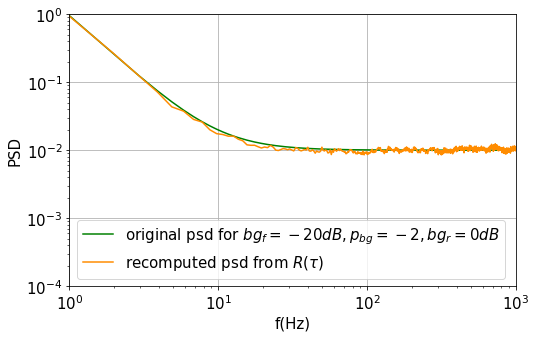

In [83]:
plt.figure(figsize=(8,5))
#plt.loglog(f,psd_mean[0:half])
plt.loglog(f,response3,label='original psd for '+'$bg_f=-20dB,p_{bg}=-2, bg_r=0dB$',c='g')
plt.loglog(f,np.abs(l)[0:half]/(N/25),label='recomputed psd from '+'$R(\\tau)$',c='darkorange')
plt.xlim([1,1000])
plt.ylim([1e-4,1])
plt.tick_params('both',labelsize=15)
plt.ylabel('PSD',fontsize=15)
plt.xlabel('f(Hz)',fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('check.jpg')